# LeNet

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Normalise data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Input 32 * 32
        x = F.relu(self.conv1(x))
        # Output 28 * 28 * 6
        x = self.pool(x)
        # Output 14 * 14 * 6
        x = F.relu(self.conv2(x))
        # Output 10 * 10 * 16
        x = self.pool(x)
        # Output 5 * 5 * 16
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

net.to(device)
print(net.conv1.bias.get_device())

cpu
-1


In [4]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=1)
epoch_num = 15
epochs = []
losses = []
for epoch in range(epoch_num):  # loop over the dataset multiple times
    total_loss = 0
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0
    
    epochs.append(epoch)
    losses.append(total_loss / 1563)


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,   500] loss: 2.181
[1,  1000] loss: 1.895
[1,  1500] loss: 1.969
[2,   500] loss: 2.220
[2,  1000] loss: 2.299
[2,  1500] loss: 2.318
[3,   500] loss: 2.378
[3,  1000] loss: 3.373
[3,  1500] loss: 2.406
[4,   500] loss: 2.406
[4,  1000] loss: 2.413
[4,  1500] loss: 2.439
[5,   500] loss: 2.428
[5,  1000] loss: 2.443
[5,  1500] loss: 2.445
[6,   500] loss: 2.486
[6,  1000] loss: 2.463
[6,  1500] loss: 2.499
[7,   500] loss: 2.476
[7,  1000] loss: 2.514
[7,  1500] loss: 2.500
[8,   500] loss: 2.486
[8,  1000] loss: 2.520
[8,  1500] loss: 2.521
[9,   500] loss: 2.506
[9,  1000] loss: 2.482
[9,  1500] loss: 2.479
[10,   500] loss: 2.476
[10,  1000] loss: 2.459
[10,  1500] loss: 2.452
[11,   500] loss: 2.454
[11,  1000] loss: 2.482
[11,  1500] loss: 2.467
[12,   500] loss: 2.494
[12,  1000] loss: 2.493
[12,  1500] loss: 2.508
[13,   500] loss: 2.509
[13,  1000] loss: 2.542
[13,  1500] loss: 2.551
[14,   500] loss: 2.549
[14,  1000] loss: 2.558
[14,  1500] loss: 2.570
[15,   500] loss: 2

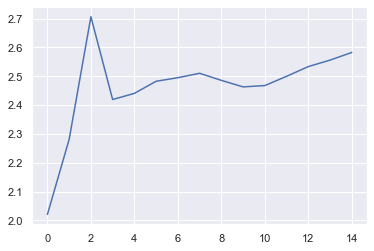

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(epochs, losses)

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {correct / total * 100:.1f}%")

Accuracy of the network on the 10000 test images: 10.0%


In [7]:
import pandas as pd
dict = {"Epoch":epochs, "Loss":losses}
df = pd.DataFrame(dict)
df.to_csv('momem1.csv', index=False) 

In [13]:
PATH = './leNet.pth'
torch.save(net.state_dict(), PATH)